In [1]:
# import packages and settings

import pandas as pd
import numpy as np
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import nltk
from nltk import word_tokenize    
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re


import warnings
warnings.filterwarnings("ignore")

In [2]:
# read data

In [3]:
train_data = pd.read_csv('TaskA-TrainingSet.csv')

In [4]:
valid_data = pd.read_csv('TaskA-ValidationSet.csv')

In [5]:
valid_data

,ID,section_header,dialogue
0,0,GENHX,Doctor: When did your pain begin? \r\nPatient:...
1,1,ROS,"Doctor: Hey, bud. What brings you in today? \r..."
2,2,PASTMEDICALHX,Doctor: Has anything changed in your medical h...
3,3,MEDICATIONS,Doctor: How've you been treating your acne? \r...
4,4,CC,Doctor: Have you been experiencing any mental ...
...,...,...,...
95,95,PROCEDURES,Doctor: How are you feeling? \r\nPatient: I a...
96,96,ROS,Doctor: How has our little man being doing?\r\...
97,97,IMAGING,"Doctor: Well, I have your E K G report, shows ..."
98,98,IMMUNIZATIONS,Doctor: Good news! No need for any shots today...


In [6]:
train_data

,ID,section_header,dialogue
0,0,GENHX,Doctor: What brings you back into the clinic t...
1,1,GENHX,Doctor: How're you feeling today? \r\nPatient...
2,2,GENHX,"Doctor: Hello, miss. What is the reason for yo..."
3,3,MEDICATIONS,Doctor: Are you taking any over the counter me...
4,4,CC,"Doctor: Hi, how are you? \r\nPatient: I burned..."
...,...,...,...
1196,1196,PASTSURGICAL,"Doctor: Good morning, sir. \r\nPatient: Good m..."
1197,1197,MEDICATIONS,"Doctor: Okay, so let's go over your medication..."
1198,1198,GENHX,"Doctor: How are you doing today, sir? \r\nPati..."
1199,1199,FAM/SOCHX,"Doctor: Hi, how's it going? \r\nPatient: Not t..."


Potential meanings for the classes:    
* ALLERGY: Information about a patient's known allergies.
* ASSESSMENT: A summary of a clinician's evaluation of a patient's condition.
* CC: Chief Complaint, the primary reason for a patient's visit to a healthcare provider.
* DIAGNOSIS: The identification of a disease or condition based on the patient's signs, symptoms, and test results.
* DISPOSITION: The patient's status or plan after an encounter, such as discharge, admission, or transfer.
* EDCOURSE: Emergency Department Course, a description of the patient's course of treatment in the emergency department.
* EXAM: Physical examination findings or information about any examinations performed on the patient.
* FAM/SOCHX: Family and Social History, information about a patient's family medical history and social background.
* GENHX: General History, a summary of the patient's overall medical history.
* GYNHX: Gynecological History, a summary of a female patient's reproductive and gynecological medical history.
* IMAGING: Information about any imaging tests performed, such as X-rays, CT scans, or MRIs.
* IMMUNIZATIONS: Information about a patient's vaccination history.
* LABS: Information about laboratory tests and their results.
* MEDICATIONS: Information about a patient's current and past medications.
* OTHER_HISTORY: Any additional history information that doesn't fit into the other categories.
* PASTMEDICALHX: Past Medical History, a record of a patient's previous health conditions and treatments.
* PASTSURGICAL: Past Surgical History, a record of a patient's previous surgeries.
* PLAN: The proposed course of action or treatment plan for a patient's condition.
* PROCEDURES: Information about any medical procedures performed or planned for the patient.
* ROS: Review of Systems, a systematic evaluation of a patient's major body systems.

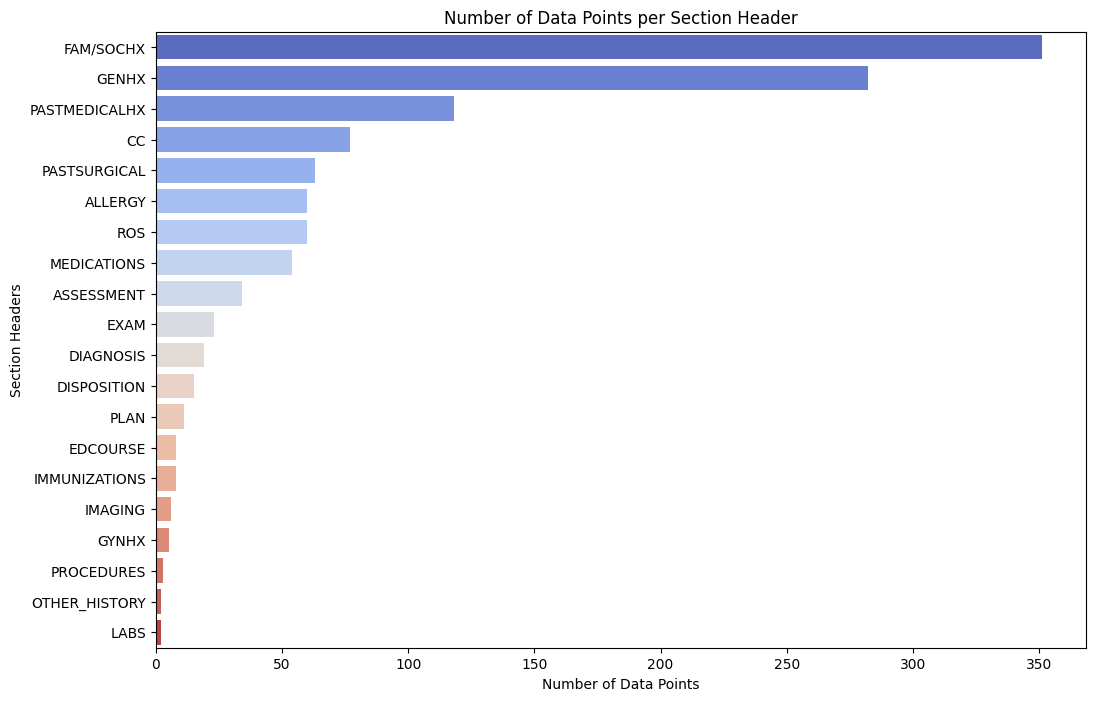

In [7]:
# EDA

# Plot the number of data points for each section header
plt.figure(figsize=(12, 8))
sns.countplot(data=train_data, y='section_header', order=train_data['section_header'].value_counts().index, palette='coolwarm')
plt.xlabel('Number of Data Points')
plt.ylabel('Section Headers')
plt.title('Number of Data Points per Section Header')
plt.show()


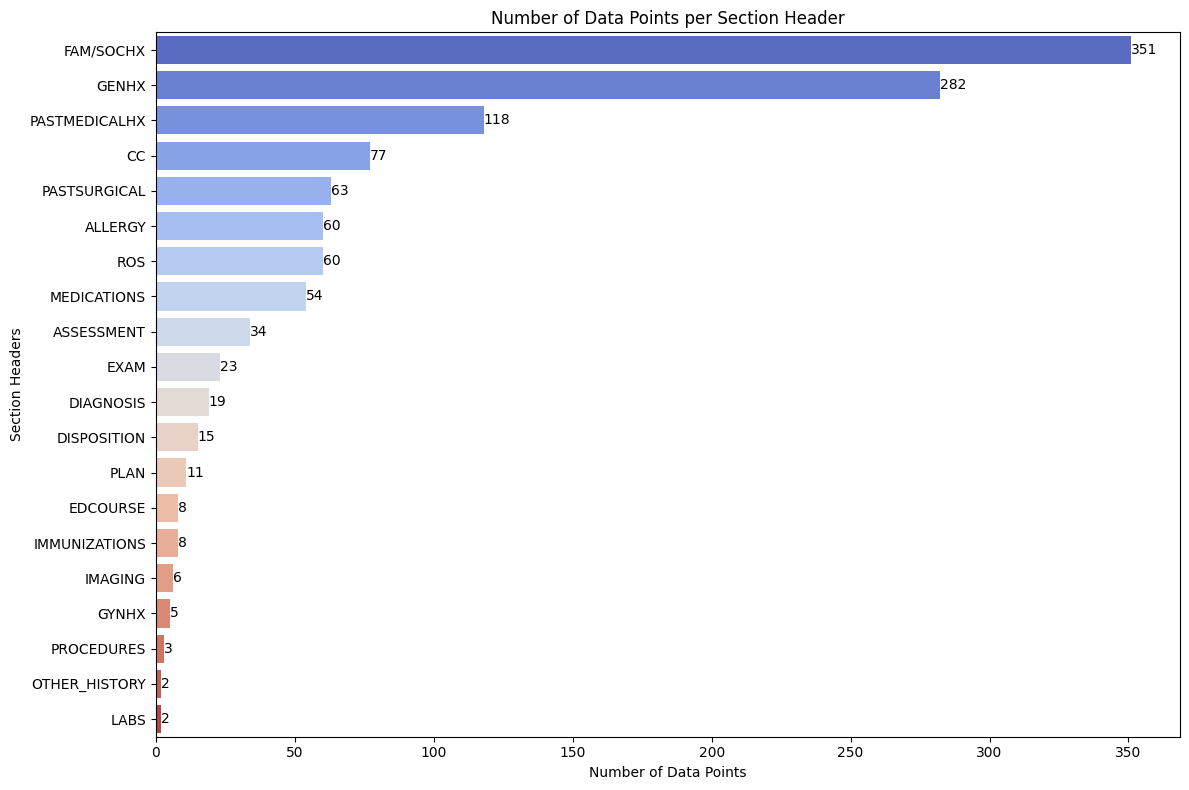

In [8]:
plt.figure(figsize=(12, 8))
plot = sns.countplot(data=train_data, y='section_header', order=train_data['section_header'].value_counts().index, palette='coolwarm')

# Adding counts on plot
for p in plot.patches:
    width = p.get_width()
    plt.text(width,  
            p.get_y() + p.get_height() / 2, 
            '{:1.0f}'.format(width), 
            ha = 'left', 
            va = 'center')

plt.xlabel('Number of Data Points')
plt.ylabel('Section Headers')
plt.title('Number of Data Points per Section Header')
plt.tight_layout()
plt.show()


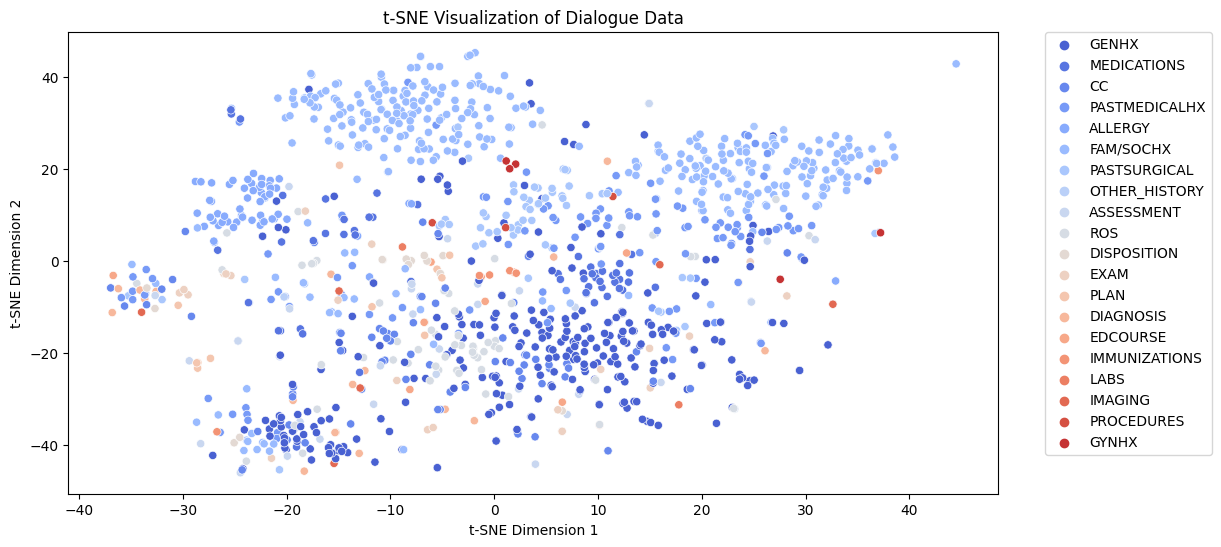

In [34]:
# Extract the dialogues and labels from the training data
dialogues = train_data['dialogue'].tolist()
labels = train_data['section_header'].tolist()

# Transform the text data into numerical vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
dialogue_vectors = tfidf_vectorizer.fit_transform(dialogues)

# Apply t-SNE 
tsne = TSNE(n_components=2, random_state=42)
dialogue_tsne = tsne.fit_transform(dialogue_vectors.toarray())

# Plot 
plt.figure(figsize=(12, 6))
sns.scatterplot(x=dialogue_tsne[:, 0], y=dialogue_tsne[:, 1], hue=labels, palette='coolwarm')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Dialogue Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


In [7]:
# count classes

In [8]:
np.unique(train_data['section_header'])

array(['ALLERGY', 'ASSESSMENT', 'CC', 'DIAGNOSIS', 'DISPOSITION',
       'EDCOURSE', 'EXAM', 'FAM/SOCHX', 'GENHX', 'GYNHX', 'IMAGING',
       'IMMUNIZATIONS', 'LABS', 'MEDICATIONS', 'OTHER_HISTORY',
       'PASTMEDICALHX', 'PASTSURGICAL', 'PLAN', 'PROCEDURES', 'ROS'],
      dtype=object)

In [9]:
len(np.unique(train_data['section_header']))

20

In [10]:
len(np.unique(valid_data['section_header']))

20

In [11]:
# assign train/ valid

X_train = train_data['dialogue']
y_train = train_data['section_header']

X_valid = valid_data['dialogue']
y_valid = valid_data['section_header']

In [12]:
# clean/ preprocess

In [13]:
stop_words = set(stopwords.words('english'))

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jiaqi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jiaqi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jiaqi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
def clean_data(text):
    
    # remove "Doctor:" and "Patient:" labels and timestamps
    text = re.sub(r"(Doctor|Patient|Guest_family):|\d{1,2}[:.]\d{1,2}\s?(AM|PM|am|pm)?", "", text)
    
    # Lowercase the text
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z\s]+", "", text)

    # Tokenize the text
    words = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join words back into a single string
    text = " ".join(words)

    return text


In [15]:
# preprocess the train data

X_train = X_train.apply(clean_data)
X_train

0       brings back clinic today miss came refill bloo...
1       howre feeling today terrible im worst headache...
2       hello miss reason visit today think wart back ...
3       taking counter medicine one prescribed alterna...
4          hi burned hand oh sorry wow yeah right arm yes
                              ...                        
1196    good morning sir good morning doctor begin eve...
1197    okay let go medication id like take help muscl...
1198    today sir honestly im pretty sick today ive go...
1199    hi hows going bad cant complain look like weat...
1200    look like nurse came asked everything ah every...
Name: dialogue, Length: 1201, dtype: object

In [16]:
X_valid = X_valid.apply(clean_data)
X_valid

0     pain begin ive low back pain eight year injury...
1     hey bud brings today rash upper arm torso star...
2     anything changed medical history since last vi...
3     howve treating acne dermatologist started accu...
4     experiencing mental difficulty confusion hallu...
                            ...                        
95    feeling well placed permanent pacemaker remove...
96    little man today well yesterday threw night na...
97    well e k g report show sinus tachycardia word ...
98    good news need shot today date immunization go...
99    im glad hear afib control id like start taking...
Name: dialogue, Length: 100, dtype: object

In [17]:
# feature extractor 

In [18]:
# tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_vec = TfidfVectorizer(stop_words='english',
                            ngram_range=(1, 2),
                            max_df=0.9,
                            # min_df=2,
                            #max_features=300
                           )

X_train = tfidf_vec.fit_transform(X_train)
X_valid = tfidf_vec.transform(X_valid)

In [19]:
print('shape of x_train features:', X_train.shape)
print('shape of x_validation features:', X_valid.shape)
print('word-index mapping dictionary:', len(tfidf_vec.vocabulary_))

shape of x_train features: (1201, 35290)
shape of x_validation features: (100, 35290)
word-index mapping dictionary: 35290


In [20]:
## oversampler

In [21]:
# Apply oversampling (on training data

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [22]:
############ model - classifier

from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [50]:
# MultinomialNB

from sklearn.naive_bayes import MultinomialNB

model_nb = MultinomialNB()

model_nb.fit(X_train, y_train)

y_pred = model_nb.predict(X_valid)

report = classification_report(y_valid, y_pred)
print(report)

               precision    recall  f1-score   support

      ALLERGY       1.00      0.25      0.40         4
   ASSESSMENT       0.00      0.00      0.00         4
           CC       0.00      0.00      0.00         4
    DIAGNOSIS       0.00      0.00      0.00         1
  DISPOSITION       0.00      0.00      0.00         2
     EDCOURSE       0.00      0.00      0.00         3
         EXAM       0.00      0.00      0.00         1
    FAM/SOCHX       0.56      1.00      0.72        22
        GENHX       0.32      0.95      0.47        20
        GYNHX       0.00      0.00      0.00         1
      IMAGING       0.00      0.00      0.00         1
IMMUNIZATIONS       0.00      0.00      0.00         1
         LABS       0.00      0.00      0.00         1
  MEDICATIONS       0.00      0.00      0.00         7
OTHER_HISTORY       0.00      0.00      0.00         1
PASTMEDICALHX       0.00      0.00      0.00         4
 PASTSURGICAL       0.00      0.00      0.00         8
         

In [51]:
### MultinomialNB hyper

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_prior': [True, False],
}


model_nb = MultinomialNB()

# Create the GridSearchCV object
grid_search = GridSearchCV(model_nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best parameters found by grid search:")
print(best_params)
print("Best score: ", grid_search.best_score_)

# Use the best estimator to make predictions
y_pred = best_estimator.predict(X_valid)

# Evaluate the performance with a classification report
report = classification_report(y_valid, y_pred)
print(report)


Best parameters found by grid search:
{'alpha': 0.1, 'fit_prior': False}
Best score:  0.6960650069156293
               precision    recall  f1-score   support

      ALLERGY       1.00      0.25      0.40         4
   ASSESSMENT       0.00      0.00      0.00         4
           CC       0.00      0.00      0.00         4
    DIAGNOSIS       0.00      0.00      0.00         1
  DISPOSITION       1.00      0.50      0.67         2
     EDCOURSE       0.00      0.00      0.00         3
         EXAM       0.00      0.00      0.00         1
    FAM/SOCHX       0.76      1.00      0.86        22
        GENHX       0.40      0.95      0.57        20
        GYNHX       0.00      0.00      0.00         1
      IMAGING       0.00      0.00      0.00         1
IMMUNIZATIONS       1.00      1.00      1.00         1
         LABS       0.00      0.00      0.00         1
  MEDICATIONS       0.75      0.43      0.55         7
OTHER_HISTORY       0.00      0.00      0.00         1
PASTMEDICALHX 

In [23]:
## LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model_lr = LogisticRegression()

model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_valid)

report = classification_report(y_valid, y_pred)
print(report)

               precision    recall  f1-score   support

      ALLERGY       1.00      0.25      0.40         4
   ASSESSMENT       0.00      0.00      0.00         4
           CC       0.25      0.25      0.25         4
    DIAGNOSIS       1.00      1.00      1.00         1
  DISPOSITION       1.00      1.00      1.00         2
     EDCOURSE       0.00      0.00      0.00         3
         EXAM       0.33      1.00      0.50         1
    FAM/SOCHX       0.88      1.00      0.94        22
        GENHX       0.58      0.90      0.71        20
        GYNHX       0.00      0.00      0.00         1
      IMAGING       0.00      0.00      0.00         1
IMMUNIZATIONS       1.00      1.00      1.00         1
         LABS       0.00      0.00      0.00         1
  MEDICATIONS       0.62      0.71      0.67         7
OTHER_HISTORY       0.00      0.00      0.00         1
PASTMEDICALHX       0.80      1.00      0.89         4
 PASTSURGICAL       0.89      1.00      0.94         8
         

In [25]:
# hyper LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500]
}


model_lr = LogisticRegression()

grid_search = GridSearchCV(model_lr, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)

report = classification_report(y_valid, y_pred)
print(report)

Best hyperparameters:  {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best score:  0.9935897435897436
               precision    recall  f1-score   support

      ALLERGY       1.00      0.25      0.40         4
   ASSESSMENT       0.00      0.00      0.00         4
           CC       0.33      0.25      0.29         4
    DIAGNOSIS       1.00      1.00      1.00         1
  DISPOSITION       1.00      1.00      1.00         2
     EDCOURSE       0.00      0.00      0.00         3
         EXAM       0.33      1.00      0.50         1
    FAM/SOCHX       0.85      1.00      0.92        22
        GENHX       0.51      0.95      0.67        20
        GYNHX       0.00      0.00      0.00         1
      IMAGING       0.00      0.00      0.00         1
IMMUNIZATIONS       1.00      1.00      1.00         1
         LABS       0.00      0.00      0.00         1
  MEDICATIONS       0.71      0.71      0.71         7
OTHER_HISTORY       0.00      0.00      0.00         1
PA

In [54]:
from sklearn import svm
from sklearn.metrics import classification_report

# Create an SVC classifier with default parameters
model_svc = svm.SVC()

# Train the model
model_svc.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model_svc.predict(X_valid)

# Compute the classification report
report = classification_report(y_valid, y_pred)
print(report)


               precision    recall  f1-score   support

      ALLERGY       1.00      0.25      0.40         4
   ASSESSMENT       0.00      0.00      0.00         4
           CC       0.00      0.00      0.00         4
    DIAGNOSIS       0.00      0.00      0.00         1
  DISPOSITION       0.00      0.00      0.00         2
     EDCOURSE       0.00      0.00      0.00         3
         EXAM       0.00      0.00      0.00         1
    FAM/SOCHX       0.71      1.00      0.83        22
        GENHX       0.36      0.95      0.52        20
        GYNHX       0.00      0.00      0.00         1
      IMAGING       0.00      0.00      0.00         1
IMMUNIZATIONS       0.00      0.00      0.00         1
         LABS       0.00      0.00      0.00         1
  MEDICATIONS       1.00      0.43      0.60         7
OTHER_HISTORY       0.00      0.00      0.00         1
PASTMEDICALHX       0.60      0.75      0.67         4
 PASTSURGICAL       1.00      0.75      0.86         8
         

In [55]:
# svc hyper

from sklearn import svm
# Define the parameter grid to search over
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Create an SVC classifier
model_svc = svm.SVC()

grid_search = GridSearchCV(model_svc, param_grid, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Make predictions on the validation set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)

# Compute the classification report for the best model
report = classification_report(y_valid, y_pred)
print(report)

Best hyperparameters:  {'C': 10, 'kernel': 'linear'}
Best score:  0.691082295988935
               precision    recall  f1-score   support

      ALLERGY       1.00      0.25      0.40         4
   ASSESSMENT       0.00      0.00      0.00         4
           CC       0.33      0.25      0.29         4
    DIAGNOSIS       0.00      0.00      0.00         1
  DISPOSITION       1.00      0.50      0.67         2
     EDCOURSE       0.00      0.00      0.00         3
         EXAM       0.50      1.00      0.67         1
    FAM/SOCHX       0.79      1.00      0.88        22
        GENHX       0.49      0.95      0.64        20
        GYNHX       0.00      0.00      0.00         1
      IMAGING       0.00      0.00      0.00         1
IMMUNIZATIONS       1.00      1.00      1.00         1
         LABS       0.00      0.00      0.00         1
  MEDICATIONS       0.67      0.57      0.62         7
OTHER_HISTORY       0.00      0.00      0.00         1
PASTMEDICALHX       0.50      0.75 

In [27]:
# mlp

from sklearn.neural_network import MLPClassifier

# Define the parameter grid to search over
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.1, 1, 10]
}

# Create an MLP classifier
model_mlp = MLPClassifier()

# Create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(model_mlp, param_grid, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Make predictions on the validation set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)

# Compute the classification report for the best model
report = classification_report(y_valid, y_pred)
print(report)

Best hyperparameters:  {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100,)}
Best score:  0.7168948824343016
               precision    recall  f1-score   support

      ALLERGY       0.00      0.00      0.00         4
   ASSESSMENT       0.00      0.00      0.00         4
           CC       0.00      0.00      0.00         4
    DIAGNOSIS       0.00      0.00      0.00         1
  DISPOSITION       0.00      0.00      0.00         2
     EDCOURSE       0.00      0.00      0.00         3
         EXAM       0.00      0.00      0.00         1
    FAM/SOCHX       0.61      1.00      0.76        22
        GENHX       0.30      0.95      0.45        20
        GYNHX       0.00      0.00      0.00         1
      IMAGING       0.00      0.00      0.00         1
IMMUNIZATIONS       0.00      0.00      0.00         1
         LABS       0.00      0.00      0.00         1
  MEDICATIONS       0.00      0.00      0.00         7
OTHER_HISTORY       0.00      0.00      0.00        

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [25]:
# dt

from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid to search over
param_grid = {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]}

# Create a Decision Tree classifier
model_dt = DecisionTreeClassifier()

# Create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(model_dt, param_grid, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Make predictions on the validation set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)

# Compute the classification report for the best model
report = classification_report(y_valid, y_pred)
print(report)

Best hyperparameters:  {'max_depth': 20, 'min_samples_split': 2}
Best score:  0.6202835408022129
               precision    recall  f1-score   support

      ALLERGY       1.00      0.25      0.40         4
   ASSESSMENT       0.00      0.00      0.00         4
           CC       0.17      0.25      0.20         4
    DIAGNOSIS       0.00      0.00      0.00         1
  DISPOSITION       0.00      0.00      0.00         2
     EDCOURSE       0.00      0.00      0.00         3
         EXAM       0.00      0.00      0.00         1
    FAM/SOCHX       0.77      0.91      0.83        22
        GENHX       0.60      0.45      0.51        20
        GYNHX       0.00      0.00      0.00         1
      IMAGING       0.00      0.00      0.00         1
IMMUNIZATIONS       0.00      0.00      0.00         1
         LABS       0.00      0.00      0.00         1
  MEDICATIONS       0.57      0.57      0.57         7
OTHER_HISTORY       0.00      0.00      0.00         1
PASTMEDICALHX       0.

In [26]:
# rf

from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20, None]}

model_rf = RandomForestClassifier()

grid_search = GridSearchCV(model_rf, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)

report = classification_report(y_valid, y_pred)
print(report)

Best hyperparameters:  {'max_depth': None, 'n_estimators': 200}
Best score:  0.7060719225449515
               precision    recall  f1-score   support

      ALLERGY       0.50      0.25      0.33         4
   ASSESSMENT       0.00      0.00      0.00         4
           CC       0.67      0.50      0.57         4
    DIAGNOSIS       0.00      0.00      0.00         1
  DISPOSITION       0.00      0.00      0.00         2
     EDCOURSE       0.00      0.00      0.00         3
         EXAM       1.00      1.00      1.00         1
    FAM/SOCHX       0.65      1.00      0.79        22
        GENHX       0.57      0.80      0.67        20
        GYNHX       0.00      0.00      0.00         1
      IMAGING       0.00      0.00      0.00         1
IMMUNIZATIONS       1.00      1.00      1.00         1
         LABS       0.00      0.00      0.00         1
  MEDICATIONS       0.67      0.86      0.75         7
OTHER_HISTORY       0.00      0.00      0.00         1
PASTMEDICALHX       0.6

In [ ]:
# adaboost

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

tree = DecisionTreeClassifier()

boost = AdaBoostClassifier(base_estimator=tree)

boost.fit(X_train, y_train)

y_pred = boost.predict(X_valid)

report = classification_report(y_valid, y_pred)
print(report)

In [ ]:
# adaboost hyper

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


param_grid = {
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__min_samples_split': [2, 3, 4],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 1],
}

tree = DecisionTreeClassifier()
boost = AdaBoostClassifier(base_estimator=tree)

# Create the GridSearchCV object
grid_search = GridSearchCV(boost, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best parameters found by grid search:")
print(best_params)
print("Best score: ", grid_search.best_score_)

# Use the best estimator to make predictions
y_pred = best_estimator.predict(X_valid)

# Evaluate the performance with a classification report
report = classification_report(y_valid, y_pred)
print(report)


In [24]:
#################################################################################
#################################################################################
#################################################################################

# Clinical BERT


In [25]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [26]:
# for BERT, we do not need normal feature extractors e.g., TfidfVectorizer

In [27]:
# read data again

train_data = pd.read_csv('TaskA-TrainingSet.csv')

valid_data = pd.read_csv('TaskA-ValidationSet.csv')

In [28]:
# assign train/ valid

X_train = train_data['dialogue']
y_train = train_data['section_header']

X_valid = valid_data['dialogue']
y_valid = valid_data['section_header']

In [29]:
# shape

len(X_train)

1201

In [30]:
len(X_valid)

100

In [31]:
# preprocess

X_train = X_train.apply(clean_data)
X_train

0       brings back clinic today miss came refill bloo...
1       howre feeling today terrible im worst headache...
2       hello miss reason visit today think wart back ...
3       taking counter medicine one prescribed alterna...
4          hi burned hand oh sorry wow yeah right arm yes
                              ...                        
1196    good morning sir good morning doctor begin eve...
1197    okay let go medication id like take help muscl...
1198    today sir honestly im pretty sick today ive go...
1199    hi hows going bad cant complain look like weat...
1200    look like nurse came asked everything ah every...
Name: dialogue, Length: 1201, dtype: object

In [32]:
y_train

0              GENHX
1              GENHX
2              GENHX
3        MEDICATIONS
4                 CC
            ...     
1196    PASTSURGICAL
1197     MEDICATIONS
1198           GENHX
1199       FAM/SOCHX
1200       FAM/SOCHX
Name: section_header, Length: 1201, dtype: object

In [33]:
X_valid = X_valid.apply(clean_data)
X_valid

0     pain begin ive low back pain eight year injury...
1     hey bud brings today rash upper arm torso star...
2     anything changed medical history since last vi...
3     howve treating acne dermatologist started accu...
4     experiencing mental difficulty confusion hallu...
                            ...                        
95    feeling well placed permanent pacemaker remove...
96    little man today well yesterday threw night na...
97    well e k g report show sinus tachycardia word ...
98    good news need shot today date immunization go...
99    im glad hear afib control id like start taking...
Name: dialogue, Length: 100, dtype: object

In [34]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [35]:
# Load the Clinical BERT tokenizer and model

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=20)


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [36]:
# define class for preprocessING for using BERT

from torch.utils.data import Dataset

class Dialogue2TopicDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_length):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        label = self.y[idx]

        # Encode
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            pad_to_max_length=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'][0],
            'attention_mask': inputs['attention_mask'][0],
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [37]:
# convert  

max_length = 307  

# Prepare label encoding
label_to_id = {label: idx for idx, label in enumerate(set(y_train))}
id_to_label = {idx: label for label, idx in label_to_id.items()}

In [38]:
# Encode labels
y_train_ids = [label_to_id[label] for label in y_train]
y_valid_ids = [label_to_id[label] for label in y_valid]

# convert datasets
train_dataset = Dialogue2TopicDataset(X_train, y_train_ids, tokenizer, max_length)
valid_dataset = Dialogue2TopicDataset(X_valid, y_valid_ids, tokenizer, max_length)

In [39]:
len(np.unique(y_valid_ids))

20

In [106]:
# Define the parameters

training_args = TrainingArguments(
    output_dir="output",
    num_train_epochs=3,  
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    learning_rate=2e-5,  
    weight_decay=0.01,  
    save_strategy="no",
)



In [107]:
# metric

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [108]:
# train model 

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# evaluation

evaluation_results = trainer.evaluate()
print(evaluation_results)


In [191]:
# report

predictions_output = trainer.predict(valid_dataset)
predicted_labels = predictions_output.predictions.argmax(-1)

y_valid_pred = [id_to_label[label_id] for label_id in predicted_labels]
y_valid_true = [id_to_label[label_id] for label_id in y_valid_ids]

report = classification_report(y_valid_true, y_valid_pred)
print(report)


               precision    recall  f1-score   support

      ALLERGY       1.00      0.50      0.67         4
   ASSESSMENT       0.00      0.00      0.00         4
           CC       0.12      0.25      0.17         4
    DIAGNOSIS       0.00      0.00      0.00         1
  DISPOSITION       0.00      0.00      0.00         2
     EDCOURSE       0.00      0.00      0.00         3
         EXAM       0.00      0.00      0.00         1
    FAM/SOCHX       0.81      0.95      0.88        22
        GENHX       0.84      0.80      0.82        20
        GYNHX       0.00      0.00      0.00         1
      IMAGING       0.00      0.00      0.00         1
IMMUNIZATIONS       0.00      0.00      0.00         1
         LABS       0.00      0.00      0.00         1
  MEDICATIONS       0.47      1.00      0.64         7
OTHER_HISTORY       0.00      0.00      0.00         1
PASTMEDICALHX       0.40      1.00      0.57         4
 PASTSURGICAL       0.78      0.88      0.82         8
         

In [54]:
# + oversampler and run Clinical BERT again

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=20)



from torch.utils.data import Dataset

class Dialogue2TopicDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_length):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        label = self.y[idx]

        # Encode
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            pad_to_max_length=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'][0],
            'attention_mask': inputs['attention_mask'][0],
            'labels': torch.tensor(label, dtype=torch.long)
        }

# convert  

max_length = 307  

# Prepare label encoding
label_to_id = {label: idx for idx, label in enumerate(set(y_train))}
id_to_label = {idx: label for label, idx in label_to_id.items()}

# Import the necessary libraries
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import numpy as np

# Oversampling 
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(
    np.array(X_train).reshape(-1, 1), y_train
)
X_train_resampled = X_train_resampled.ravel()

print("Before oversampling:", Counter(y_train))
print("After oversampling:", Counter(y_train_resampled))

# Encode label
y_train_ids = [label_to_id[label] for label in y_train_resampled]  
y_valid_ids = [label_to_id[label] for label in y_valid]

# convert dataset
train_dataset = Dialogue2TopicDataset(X_train_resampled, y_train_ids, tokenizer, max_length)  
valid_dataset = Dialogue2TopicDataset(X_valid, y_valid_ids, tokenizer, max_length)

# Define the perameters

training_args = TrainingArguments(
    output_dir="output",
    num_train_epochs=3,  
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    learning_rate=2e-5,  
    weight_decay=0.01,  
    save_strategy="no",
)

# metric

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

#  train model 

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

# evaluation

evaluation_results = trainer.evaluate()
print(evaluation_results)

# report

from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

predictions_output = trainer.predict(valid_dataset)
predicted_labels = predictions_output.predictions.argmax(-1)

y_valid_pred = [id_to_label[label_id] for label_id in predicted_labels]
y_valid_true = [id_to_label[label_id] for label_id in y_valid_ids]

report = classification_report(y_valid_true, y_valid_pred)
print(report)


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Before oversampling: Counter({'FAM/SOCHX': 351, 'GENHX': 282, 'PASTMEDICALHX': 118, 'CC': 77, 'PASTSURGICAL': 63, 'ALLERGY': 60, 'ROS': 60, 'MEDICATIONS': 54, 'ASSESSMENT': 34, 'EXAM': 23, 'DIAGNOSIS': 19, 'DISPOSITION': 15, 'PLAN': 11, 'EDCOURSE': 8, 'IMMUNIZATIONS': 8, 'IMAGING': 6, 'GYNHX': 5, 'PROCEDURES': 3, 'OTHER_HISTORY': 2, 'LABS': 2})
After oversampling: Counter({'GENHX': 351, 'MEDICATIONS': 351, 'CC': 351, 'PASTMEDICALHX': 351, 'ALLERGY': 351, 'FAM/SOCHX': 351, 'PASTSURGICAL': 351, 'OTHER_HISTORY': 351, 'ASSESSMENT': 351, 'ROS': 351, 'DISPOSITION': 351, 'EXAM': 351, 'PLAN': 351, 'DIAGNOSIS': 351, 'EDCOURSE': 351, 'IMMUNIZATIONS': 351, 'LABS': 351, 'IMAGING': 351, 'PROCEDURES': 351, 'GYNHX': 351})


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.504000,1.221193,0.680000,0.677644,0.723437,0.680000
2,0.064800,1.477720,0.710000,0.698734,0.731607,0.710000
3,0.022100,1.430895,0.730000,0.714825,0.719671,0.730000


{'eval_loss': 1.4308947324752808, 'eval_accuracy': 0.73, 'eval_f1': 0.7148252531781946, 'eval_precision': 0.7196710526315789, 'eval_recall': 0.73, 'eval_runtime': 31.0234, 'eval_samples_per_second': 3.223, 'eval_steps_per_second': 0.419, 'epoch': 3.0}
               precision    recall  f1-score   support

      ALLERGY       1.00      0.50      0.67         4
   ASSESSMENT       0.67      0.50      0.57         4
           CC       0.17      0.25      0.20         4
    DIAGNOSIS       0.00      0.00      0.00         1
  DISPOSITION       0.00      0.00      0.00         2
     EDCOURSE       1.00      0.67      0.80         3
         EXAM       1.00      1.00      1.00         1
    FAM/SOCHX       0.78      0.95      0.86        22
        GENHX       0.84      0.80      0.82        20
        GYNHX       0.00      0.00      0.00         1
      IMAGING       0.00      0.00      0.00         1
IMMUNIZATIONS       1.00      1.00      1.00         1
         LABS       0.00      0.

In [40]:
# + oversampler and run Clinical BERT again - v.2

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=20)



from torch.utils.data import Dataset

class Dialogue2TopicDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_length):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        label = self.y[idx]

        # Encode
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            pad_to_max_length=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'][0],
            'attention_mask': inputs['attention_mask'][0],
            'labels': torch.tensor(label, dtype=torch.long)
        }

# convert  

max_length = 307  

# Prepare label encoding
label_to_id = {label: idx for idx, label in enumerate(set(y_train))}
id_to_label = {idx: label for label, idx in label_to_id.items()}

# Import the necessary libraries
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import numpy as np

# Oversampling 
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(
    np.array(X_train).reshape(-1, 1), y_train
)
X_train_resampled = X_train_resampled.ravel()

print("Before oversampling:", Counter(y_train))
print("After oversampling:", Counter(y_train_resampled))

# Encode label
y_train_ids = [label_to_id[label] for label in y_train_resampled]  
y_valid_ids = [label_to_id[label] for label in y_valid]

# convert dataset
train_dataset = Dialogue2TopicDataset(X_train_resampled, y_train_ids, tokenizer, max_length)  
valid_dataset = Dialogue2TopicDataset(X_valid, y_valid_ids, tokenizer, max_length)

# Define the perameters

# training_args = TrainingArguments(
#     output_dir="output",
#     num_train_epochs=3,  
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=8,
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,  
#     weight_decay=0.001,  
#     save_strategy="no",
# )

training_args = TrainingArguments(
    output_dir="output",
    num_train_epochs=3,  
    per_device_train_batch_size=4,  # Smaller batch sizes might help to regularize the model
    per_device_eval_batch_size=8,  
    evaluation_strategy="epoch",  
    learning_rate=1e-4,  # Use a smaller learning rate to avoid large updates
    weight_decay=0.05,  # Increase weight decay to add regularization
    # save_strategy="no",
    # load_best_model_at_end=True,  # load the best model after training.
    metric_for_best_model="accuracy",  
    greater_is_better=True,  # Set to True if higher metric values are better, e.g., accuracy or F1 score.
)


# metric

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

#  train model 

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

# evaluation

evaluation_results = trainer.evaluate()
print(evaluation_results)

# report

from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

predictions_output = trainer.predict(valid_dataset)
predicted_labels = predictions_output.predictions.argmax(-1)

y_valid_pred = [id_to_label[label_id] for label_id in predicted_labels]
y_valid_true = [id_to_label[label_id] for label_id in y_valid_ids]

report = classification_report(y_valid_true, y_valid_pred)
print(report)


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Before oversampling: Counter({'FAM/SOCHX': 351, 'GENHX': 282, 'PASTMEDICALHX': 118, 'CC': 77, 'PASTSURGICAL': 63, 'ALLERGY': 60, 'ROS': 60, 'MEDICATIONS': 54, 'ASSESSMENT': 34, 'EXAM': 23, 'DIAGNOSIS': 19, 'DISPOSITION': 15, 'PLAN': 11, 'EDCOURSE': 8, 'IMMUNIZATIONS': 8, 'IMAGING': 6, 'GYNHX': 5, 'PROCEDURES': 3, 'OTHER_HISTORY': 2, 'LABS': 2})
After oversampling: Counter({'GENHX': 351, 'MEDICATIONS': 351, 'CC': 351, 'PASTMEDICALHX': 351, 'ALLERGY': 351, 'FAM/SOCHX': 351, 'PASTSURGICAL': 351, 'OTHER_HISTORY': 351, 'ASSESSMENT': 351, 'ROS': 351, 'DISPOSITION': 351, 'EXAM': 351, 'PLAN': 351, 'DIAGNOSIS': 351, 'EDCOURSE': 351, 'IMMUNIZATIONS': 351, 'LABS': 351, 'IMAGING': 351, 'PROCEDURES': 351, 'GYNHX': 351})


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.289300,1.684569,0.660000,0.641023,0.674933,0.660000
2,0.085500,2.158986,0.680000,0.656899,0.654673,0.680000
3,0.038100,2.223348,0.670000,0.616524,0.605672,0.670000


{'eval_loss': 2.2233476638793945, 'eval_accuracy': 0.67, 'eval_f1': 0.6165236866596066, 'eval_precision': 0.6056719576719577, 'eval_recall': 0.67, 'eval_runtime': 31.2669, 'eval_samples_per_second': 3.198, 'eval_steps_per_second': 0.416, 'epoch': 3.0}
               precision    recall  f1-score   support

      ALLERGY       0.50      0.50      0.50         4
   ASSESSMENT       0.00      0.00      0.00         4
           CC       0.50      0.25      0.33         4
    DIAGNOSIS       0.00      0.00      0.00         1
  DISPOSITION       0.00      0.00      0.00         2
     EDCOURSE       0.00      0.00      0.00         3
         EXAM       1.00      1.00      1.00         1
    FAM/SOCHX       0.79      1.00      0.88        22
        GENHX       0.63      0.85      0.72        20
        GYNHX       0.00      0.00      0.00         1
      IMAGING       0.00      0.00      0.00         1
IMMUNIZATIONS       1.00      1.00      1.00         1
         LABS       0.00      0.

In [41]:
# ======================================================================================== 
# ======================================================================================== 
# ======================================================================================== 
# ============================= try to tune Clinical BERT

In [59]:
# !pip install optuna

In [60]:
import numpy as np
from transformers import TrainingArguments
import optuna

def model_init():
    return AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=20)

def objective(trial):
    training_args = TrainingArguments(
        output_dir="output",
        num_train_epochs=trial.suggest_int("num_train_epochs", 1, 5),
        per_device_train_batch_size=trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32]),
        per_device_eval_batch_size=8,
        evaluation_strategy="epoch",
        learning_rate=trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
        weight_decay=trial.suggest_float("weight_decay", 0, 0.1),
        save_strategy="no",
    )

    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    evaluation_results = trainer.evaluate()
    return evaluation_results["eval_f1"]  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)  # more trials, the better the fine-tuning


[I 2023-05-03 00:54:29,045] A new study created in memory with name: no-name-f094bdb1-6306-4a5b-9ef7-e7d5287798d6
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertF

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,2.727694,0.220000,0.079344,0.048400,0.220000
2,2.424800,2.866024,0.220000,0.079344,0.048400,0.220000
3,2.424800,2.997134,0.220000,0.079344,0.048400,0.220000
4,2.321700,2.663121,0.220000,0.079344,0.048400,0.220000
5,2.262500,2.649045,0.220000,0.079344,0.048400,0.220000


[I 2023-05-03 02:26:55,837] Trial 0 finished with value: 0.07934426229508197 and parameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'learning_rate': 0.0007344673602424301, 'weight_decay': 0.0319734592709151}. Best is trial 0 with value: 0.07934426229508197.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Be

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.598735,0.600000,0.523481,0.485363,0.600000
2,No log,1.407836,0.610000,0.549629,0.554960,0.610000


[I 2023-05-03 02:58:25,624] Trial 1 finished with value: 0.5496291486291487 and parameters: {'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'learning_rate': 0.0001821563840773997, 'weight_decay': 0.046919563979056104}. Best is trial 1 with value: 0.5496291486291487.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing B

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,2.177548,0.360000,0.234902,0.200500,0.360000


[I 2023-05-03 03:13:48,611] Trial 2 finished with value: 0.23490196078431375 and parameters: {'num_train_epochs': 1, 'per_device_train_batch_size': 32, 'learning_rate': 4.428531314994795e-05, 'weight_decay': 0.0579009064547816}. Best is trial 1 with value: 0.5496291486291487.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Be

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.500141,0.590000,0.492913,0.435325,0.590000


[I 2023-05-03 03:30:44,797] Trial 3 finished with value: 0.4929128462979394 and parameters: {'num_train_epochs': 1, 'per_device_train_batch_size': 8, 'learning_rate': 0.00011002906769622815, 'weight_decay': 0.044111197580348684}. Best is trial 1 with value: 0.5496291486291487.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing B

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,2.738574,0.220000,0.079344,0.048400,0.220000
2,No log,2.760457,0.200000,0.066667,0.040000,0.200000
3,No log,2.673742,0.220000,0.079344,0.048400,0.220000
4,2.232900,2.329295,0.380000,0.260906,0.224167,0.380000


[I 2023-05-03 04:36:45,571] Trial 4 finished with value: 0.2609057971014493 and parameters: {'num_train_epochs': 4, 'per_device_train_batch_size': 8, 'learning_rate': 0.0002594779079289271, 'weight_decay': 0.015104202932722854}. Best is trial 1 with value: 0.5496291486291487.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Be

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,2.402022,0.400000,0.266154,0.212762,0.400000
2,No log,2.417658,0.390000,0.268252,0.233687,0.390000
3,No log,2.299688,0.400000,0.274638,0.235965,0.400000
4,1.868300,2.303664,0.410000,0.274593,0.225906,0.410000


[I 2023-05-03 05:42:48,348] Trial 5 finished with value: 0.2745929339477727 and parameters: {'num_train_epochs': 4, 'per_device_train_batch_size': 8, 'learning_rate': 0.00023048730134584818, 'weight_decay': 0.05809901832774703}. Best is trial 1 with value: 0.5496291486291487.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Be

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,2.759868,0.380000,0.224103,0.159156,0.380000
2,2.117600,2.753057,0.200000,0.066667,0.040000,0.200000
3,2.117600,2.696909,0.220000,0.079344,0.048400,0.220000
4,2.229600,2.642693,0.220000,0.079344,0.048400,0.220000


[I 2023-05-03 06:55:35,809] Trial 6 finished with value: 0.07934426229508197 and parameters: {'num_train_epochs': 4, 'per_device_train_batch_size': 4, 'learning_rate': 0.00017743881463958697, 'weight_decay': 0.053486782539309885}. Best is trial 1 with value: 0.5496291486291487.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,2.221513,0.360000,0.230133,0.189324,0.360000
2,No log,1.920540,0.440000,0.319584,0.344230,0.440000
3,No log,1.773425,0.540000,0.464396,0.486254,0.540000
4,No log,1.697675,0.560000,0.503948,0.572357,0.560000
5,No log,1.654257,0.590000,0.543425,0.585636,0.590000


[I 2023-05-03 08:12:42,953] Trial 7 finished with value: 0.5434245359903255 and parameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'learning_rate': 1.1691240864914758e-05, 'weight_decay': 0.09936078481652363}. Best is trial 1 with value: 0.5496291486291487.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing B

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,2.133188,0.370000,0.227666,0.172591,0.370000
2,No log,1.963414,0.410000,0.270208,0.229357,0.410000


[I 2023-05-03 08:45:49,131] Trial 8 finished with value: 0.2702075471698113 and parameters: {'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'learning_rate': 1.0332602910717996e-05, 'weight_decay': 0.06184322628277287}. Best is trial 1 with value: 0.5496291486291487.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Be

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,2.678782,0.200000,0.066667,0.040000,0.200000


[I 2023-05-03 09:02:54,829] Trial 9 finished with value: 0.06666666666666668 and parameters: {'num_train_epochs': 1, 'per_device_train_batch_size': 8, 'learning_rate': 0.0005573249068107314, 'weight_decay': 0.01633244797898207}. Best is trial 1 with value: 0.5496291486291487.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Be

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.730585,0.550000,0.486790,0.458935,0.550000
2,No log,1.430747,0.620000,0.565244,0.571788,0.620000


[I 2023-05-03 09:34:25,210] Trial 10 finished with value: 0.5652439858777892 and parameters: {'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'learning_rate': 5.6153014625142144e-05, 'weight_decay': 0.005866976830502982}. Best is trial 10 with value: 0.5652439858777892.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializin

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.734546,0.550000,0.490244,0.464829,0.550000
2,No log,1.435127,0.620000,0.565244,0.571788,0.620000


[I 2023-05-03 10:05:42,406] Trial 11 finished with value: 0.5652439858777892 and parameters: {'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'learning_rate': 5.5800950717831996e-05, 'weight_decay': 0.00023886056576580272}. Best is trial 10 with value: 0.5652439858777892.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializ

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.818244,0.510000,0.433992,0.412714,0.510000
2,No log,1.509952,0.620000,0.565920,0.560535,0.620000


[I 2023-05-03 10:36:31,914] Trial 12 finished with value: 0.5659204205542239 and parameters: {'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'learning_rate': 4.68641162827329e-05, 'weight_decay': 0.001524419301528795}. Best is trial 12 with value: 0.5659204205542239.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.885408,0.460000,0.373533,0.338931,0.460000
2,No log,1.525974,0.630000,0.572337,0.590894,0.630000
3,No log,1.419427,0.650000,0.598331,0.581443,0.650000


[I 2023-05-03 11:22:44,352] Trial 13 finished with value: 0.5983306764157829 and parameters: {'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'learning_rate': 3.5909539687097195e-05, 'weight_decay': 0.002211910771361521}. Best is trial 13 with value: 0.5983306764157829.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializin

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.952724,0.400000,0.279216,0.243243,0.400000
2,No log,1.649201,0.620000,0.574305,0.582375,0.620000
3,No log,1.562522,0.640000,0.593120,0.577028,0.640000


[I 2023-05-03 12:09:44,997] Trial 14 finished with value: 0.5931203007518797 and parameters: {'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'learning_rate': 2.6421593160509734e-05, 'weight_decay': 0.0019242418194512902}. Best is trial 13 with value: 0.5983306764157829.


In [61]:
print("Best trial:")
trial_ = study.best_trial
print(f"  Value: {trial_.value}")
print("  Params: ")
for key, value in trial_.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.5983306764157829
  Params: 
    num_train_epochs: 3
    per_device_train_batch_size: 16
    learning_rate: 3.5909539687097195e-05
    weight_decay: 0.002211910771361521


In [62]:
# Retrain model with the best hyperparameters
best_params = trial_.params

In [63]:
training_args = TrainingArguments(
    output_dir="output",
    num_train_epochs=best_params["num_train_epochs"],
    per_device_train_batch_size=best_params["per_device_train_batch_size"],
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    weight_decay=best_params["weight_decay"],
    save_strategy="no",
)

In [64]:
# Instantiate the Trainer with the best hyperparameters
trainer = Trainer(
    model=model_init(),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluation
evaluation_results = trainer.evaluate()
print(evaluation_results)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.845319,0.450000,0.411644,0.421812,0.450000
2,No log,1.510837,0.610000,0.566803,0.552672,0.610000
3,No log,1.441269,0.650000,0.604373,0.583742,0.650000


{'eval_loss': 1.441269040107727, 'eval_accuracy': 0.65, 'eval_f1': 0.604373389824157, 'eval_precision': 0.5837415654520917, 'eval_recall': 0.65, 'eval_runtime': 30.9714, 'eval_samples_per_second': 3.229, 'eval_steps_per_second': 0.42, 'epoch': 3.0}


In [65]:
# Predictions
predictions_output = trainer.predict(valid_dataset)
predicted_labels = predictions_output.predictions.argmax(-1)

# Convert label IDs to original labels
y_valid_pred = [id_to_label[label_id] for label_id in predicted_labels]
y_valid_true = [id_to_label[label_id] for label_id in y_valid_ids]

# Generate classification report
from sklearn.metrics import classification_report
report = classification_report(y_valid_true, y_valid_pred, zero_division=1)
print(report)

               precision    recall  f1-score   support

      ALLERGY       0.67      0.50      0.57         4
   ASSESSMENT       1.00      0.00      0.00         4
           CC       0.15      0.50      0.24         4
    DIAGNOSIS       1.00      0.00      0.00         1
  DISPOSITION       1.00      0.00      0.00         2
     EDCOURSE       1.00      0.00      0.00         3
         EXAM       1.00      0.00      0.00         1
    FAM/SOCHX       0.88      0.95      0.91        22
        GENHX       0.84      0.80      0.82        20
        GYNHX       1.00      0.00      0.00         1
      IMAGING       1.00      0.00      0.00         1
IMMUNIZATIONS       1.00      0.00      0.00         1
         LABS       1.00      0.00      0.00         1
  MEDICATIONS       0.78      1.00      0.88         7
OTHER_HISTORY       1.00      0.00      0.00         1
PASTMEDICALHX       0.33      1.00      0.50         4
 PASTSURGICAL       0.78      0.88      0.82         8
         

In [34]:
# ======================================================================================== commented codes

In [200]:
# just a vis for determin max_length

In [201]:
# import matplotlib.pyplot as plt

# text_lengths = [len(tokenizer.encode(text)) for text in X_train]
# plt.hist(text_lengths, bins=50)
# plt.xlabel('Text Length')
# plt.ylabel('Frequency')
# plt.show()


In [202]:
# import numpy as np

# percentile_90 = int(np.percentile(text_lengths, 90))
# percentile_95 = int(np.percentile(text_lengths, 95))
# percentile_99 = int(np.percentile(text_lengths, 99))

# print(f"90th percentile: {percentile_90}")
# print(f"95th percentile: {percentile_95}")
# print(f"99th percentile: {percentile_99}")


In [31]:
# see features

# vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,5), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
# tfIdfMat  = vectorizer.fit_transform(X_train.tolist())
# feature_names = sorted(vectorizer.get_feature_names())
# print(feature_names)

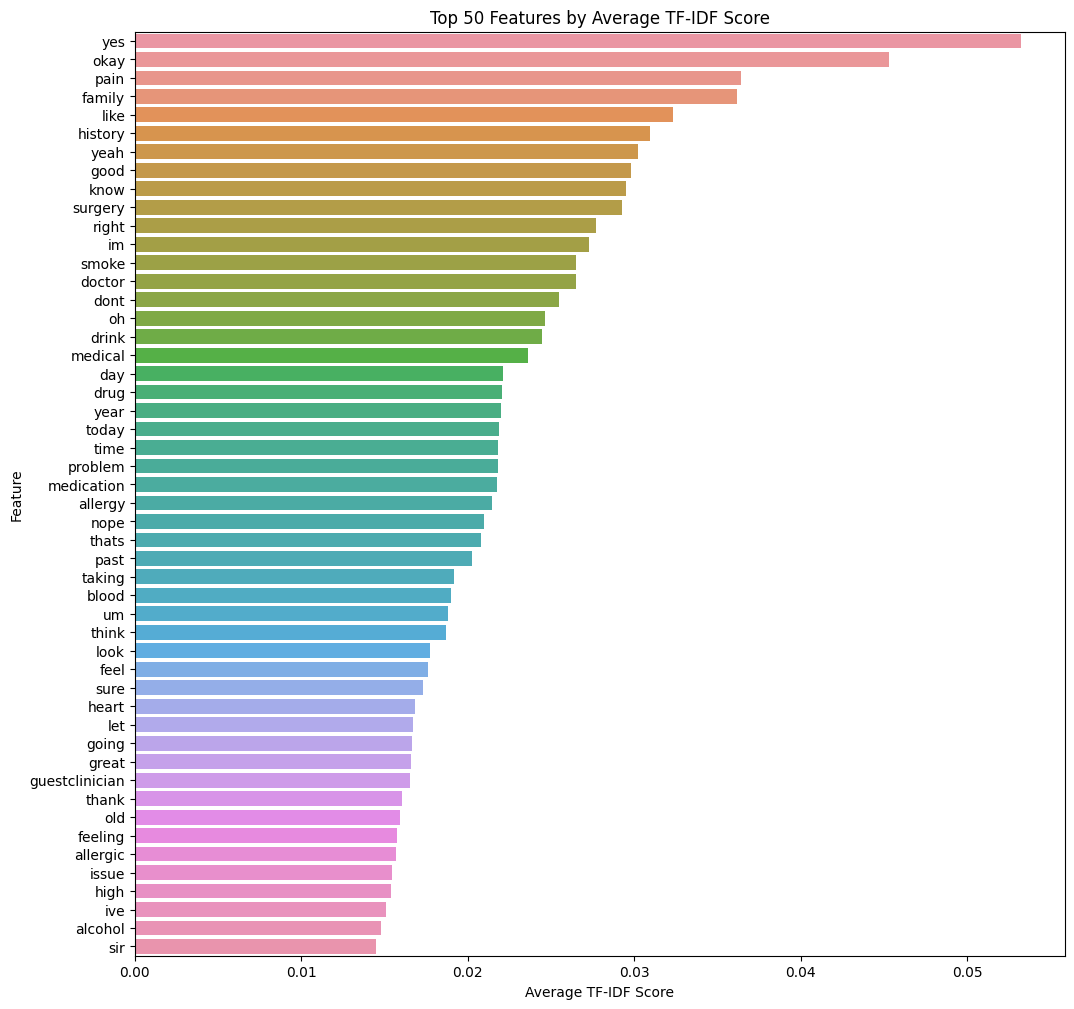

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


avg_tfidf_scores = np.mean(tfIdfMat.toarray(), axis=0)

feature_scores = pd.DataFrame({'feature': feature_names, 'avg_tfidf': avg_tfidf_scores})

sorted_feature_scores = feature_scores.sort_values(by='avg_tfidf', ascending=False)

top_n = 50
plt.figure(figsize=(12, 12))
sns.barplot(data=sorted_feature_scores.head(top_n), x='avg_tfidf', y='feature')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Features by Average TF-IDF Score')
plt.show()

In [32]:
### add hand-coded features

section_keywords = {
    "ALLERGY": ["allergy", "allergies", "allergic", "reaction", "hypersensitivity", "anaphylaxis"],
    "ASSESSMENT": ["assessment", "evaluate", "evaluation", "examine", "analysis", "appraisal"],
    "CC": ["chief complaint", "complaint", "symptom", "presenting", "concern", "issue"],
    "DIAGNOSIS": ["diagnosis", "diagnose", "condition", "finding", "disease", "disorder"],
    "DISPOSITION": ["disposition", "discharge", "admit", "transfer", "status", "outcome"],
    "EDCOURSE": ["ed course", "emergency department", "treatment", "management", "care", "therapy"],
    "EXAM": ["physical exam", "examination", "inspection", "auscultation", "palpation", "assessment"],
    "FAM/SOCHX": ["family history", "social history", "lifestyle", "habits", "relationships", "environment"],
    "GENHX": ["general history", "medical history", "background", "chronic", "illness", "disease"],
    "GYNHX": ["gynecological history", "gynecology", "reproductive", "menstruation", "pregnancy", "contraception"],
    "IMAGING": ["imaging", "x-ray", "ultrasound", "ct", "mri", "radiology", "scan", "radiograph"],
    "IMMUNIZATIONS": ["immunizations", "vaccinations", "vaccine", "shot", "immunity", "inoculation"],
    "LABS": ["labs", "laboratory", "blood work", "test results", "analysis", "diagnostics"],
    "MEDICATIONS": ["medications", "drugs", "prescriptions", "meds", "pharmacotherapy", "pharmaceuticals"],
    "OTHER_HISTORY": ["other history", "additional history", "miscellaneous", "unrelated", "extra", "supplementary"],
    "PASTMEDICALHX": ["past medical history", "pmh", "previous conditions", "comorbidities", "illnesses", "disorders"],
    "PASTSURGICAL": ["past surgical", "surgical history", "operations", "procedures", "interventions", "surgeries"],
    "PLAN": ["plan", "treatment plan", "interventions", "actions", "approach", "strategy"],
    "PROCEDURES": ["procedures", "interventions", "techniques", "operations", "methods", "practices"],
    "ROS": ["review of systems", "ros", "systematic review", "organ systems", "body systems", "clinical review"],
}


In [33]:
# import numpy as np
# import pandas as pd
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.pipeline import FeatureUnion
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report

# class SectionKeywordTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, section_keywords):
#         self.section_keywords = section_keywords

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         features = np.zeros((len(X), len(self.section_keywords)))

#         for i, text in enumerate(X):
#             for j, section in enumerate(self.section_keywords):
#                 keywords = self.section_keywords[section]
#                 for keyword in keywords:
#                     if keyword in text.lower():
#                         features[i, j] += 1

#         return features

    
# feature_union = FeatureUnion([
#     ('tfidf', TfidfVectorizer(stop_words='english')),
#     ('section_keywords', SectionKeywordTransformer(section_keywords))
# ])


# X_train = feature_union.fit_transform(X_train)
# X_valid = feature_union.transform(X_valid)


# model_svm = SVC(C=1, kernel='linear') 
# model_svm.fit(X_train, y_train)
# y_pred = model_svm.predict(X_valid)


# report = classification_report(y_valid, y_pred)
# print(report)